In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import DataLoader

from torchaudio.transforms import Spectrogram, MelScale, MelSpectrogram
from torchvision.transforms import Resize, ToPILImage, ToTensor

from Utils import imshow, train, evaluate, plot_loss
from Transformations import CenterCrop, AdaptivePad1d, AppendChannel, Transpose, Compose
from Models import TorchismNet, GenreResnet101, GenreLSTM, TorchismNet1d, ResTorchism, ResTorchism24
from Datasets import FMAWav

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Torchism
Standardni pristup u klasifikaciji zvucnog zapisa po bilo kojoj osnovi je prevodjenje zvucnog signala u spektrogram i zatim primena klasicnih modela racunarske vizije nad rezultujucim spektrogramom. Model Torchism je jedan nacin da se izvede bas taj pristup.

Standardna konvolutivna neuronska mreza se sastoji od konvolutivnog dela (ekstratkor atributa) i potpuno povezanog dela (klasifikator). Sam ekstraktor atributa ne zavisi od dimenzija ulaznog vektora sto proizilazi iz definicije operacije konvolucije, tj. njene klizuce primene. Potpuno povezan deo je taj koji je strogo definisan u terminima dimenzija ulaznog i izlaznog vektora i on je srz toga sto odrenjene arhitekture premda pocinju ekstraktorom atributa, ipak imaju definisanu neophodnu dimenziju ulaza. Kako bismo zaobisli ovo ogranicenje, pri prelasku sa konvolutivnog na potpuno povezani deo, umesto standardne operacije izravnjivanja mape atributa (feature map flattening) primenjujemo drugu strategiju. Kako je broj kernela proizvoljna odluka pri dizajniranju arhitekture, a ta odluka na n-tom sloju definise broj ulaznih kanala n+1-og sloja, odlucio sam da moja arhitektura (Torchism) na poslednjem konvolutivnom sloju primeni onoliko kernela koliko imamo klasa (16), a zatim adaptivni agregirajuci sloj (Adaptive Max Pooling) kako bi svaki kanal izlazne mape atributa bio dimenzije 1x1. Kombinacijom ove dve strategije dobijamo kao rezultat da ekstraktor atributa na izlazu vrati nesto sto lici na logite nad kojima mozemo direktno primeniti aktivaciju mekog maksimuma (Softmax) i dobiti raspodelu nad klasama.

Kerneli korisceni u ovoj arhitekturi su dimenzija 3x3, nakon svakog su primenjeni grupisana normalizacija (Batch Normalization) i izlomljena linearna aktivacija (ReLU) izuzev poslednjeg sloja gde je primenjen adaptivni agregirajuci sloj (Adaptive Max Pooling) i aktivacija mekog maksimuma (Softmax). Slojeva ukupno ima osam, a broj kernela po svakom sloju je redom: 2 (ulazni spektrogram), 16 (broj klasa), 32, 48, 80, 112, 64, 32, 16 (izlazni sloj). U svakom sloju je broj kanala zapravo odredjeni umnozak broja klasa, ova odluka nije opravdana razumom.

In [ ]:
data_train = FMAWav('medium', 'training', transform=Spectrogram())
data_val = FMAWav('medium', 'validation', transform=Spectrogram())
model = TorchismNet(num_classes=len(data_train.genres)).to(device)

In [ ]:
model, loss_train, loss_val = train(
    model=model,
    train_loader=DataLoader(data_train, batch_size=1, num_workers=4),
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.003),
    epochs=1,
    val_loader=DataLoader(data_val, batch_size=1, num_workers=4),
    val_count=1000,
    model_dir='models',
    model_name='torchism_medium'
)

In [ ]:
plot_loss(loss_train, loss_val)

In [ ]:
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

Rezultati ovog pristupa su nezadovoljavajuci. Na skupu za izbor modela (validation set) je model za svaki ulaz dao predvidjanje "Rock".

# ResNet101
Sledeci pokusaj se svodio na isti pristup, ali sa poznatom arhitekturom - ResNet101. Pre treninga je bilo potrebno prilagoditi ulaz ocekivanim dimenzijama. Ovo se postize primenom rucno definim transformacijama:
* AdaptivePad1d - Dopunjuje ulaznu sekvancu nulama sa leve strane
* AppendChannel - Dodaje kanal dopunjen nulama kako bi ulaz imao tri kanala koliko je ocekivano

In [ ]:
transformations = Compose([
    AdaptivePad1d(max_size=1439471),
    Spectrogram(),
    ToPILImage(),
    Resize((224, 224)),
    ToTensor(),
    AppendChannel(),
])
data_train = FMAWav('medium', 'training', transform=transformations)
data_val = FMAWav('medium', 'validation', transform=transformations)
model = GenreResnet101(len(data_train.genres)).to(device)

In [ ]:
model, loss_train, loss_val = train(
    model=model,
    train_loader=DataLoader(data_train, batch_size=32, num_workers=4),
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    epochs=1,
    val_loader=DataLoader(data_val, batch_size=8, num_workers=0),
    val_count=211,
    model_dir='models',
    model_name='resnet101_medium_new'
)

In [ ]:
plot_loss(loss_train, loss_val)

In [ ]:
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

Rezultati ResNet101 modela nisu bili dovoljno dobri. Pretpostavka je da je ovakvo preprocesiranje ulaza unelo previse suma iz kojeg nije moglo da se zakljuci previse. Druga mogucnost koja se javila u retrospektivi je da je trening zaustaljen pre nego sto je model mogao nesto nauciti. Zanimljiv eksperiment u buducnosti bi bio ponoviti trening sa velikim brojem epoha. Sam rezultat ovog pristupa je bio slican prethodnom, vecina predikcija su bile usmerene ka jednoj od dve najzastupljenije klase: Rock i Electronic. Pretpostavka je da su takvi parametri modela koji predvidjaju jednu samo jednu od ove dve klase zapravo lokalni ekstremumi i da zavisno od pocetne inicijalizacije, model ostane zaglavljen u jednom od ova dva optimuma. Adaptivnost koraka ucenja ADAM optimizatora se ispostavlja da je mac sa dve ostrice narocito u slucaju lokalnih optimuma, te bi interesantan eksperiment bio pokrenuti [ciklicno ucenje](https://arxiv.org/abs/1506.01186).

# LSTM
Sledeci standardni pristup klasifikaciji zvucnog signala je koriscenje rekurentnih neuronskih mreza. Najzastupljenija ovakva mreza je svakako LSTM. Arhitektura koriscena je jedna LSTM celija sa dva skrivena sloja i dimenzijom stanja 20.

In [ ]:
transformations = Transpose()
data_train = FMAWav('small', 'training', transform=transformations)
data_val = FMAWav('small', 'validation', transform=transformations)
model = GenreLSTM(len(data_train.genres)).to(device)

In [ ]:
model, loss_train, loss_val = train(
    model=model,
    train_loader=DataLoader(data_train, batch_size=1, num_workers=4),
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    epochs=1,
    val_loader=DataLoader(data_val, batch_size=1, num_workers=4),
    val_count=1000,
    model_dir='models',
    model_name='genrelstm_small'
)

In [ ]:
plot_loss(loss_train, loss_val)

In [ ]:
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

Obucavanje ovakve arhitekture je zaustavljen pre nego sto je moglo i da se stigne do konvergencije. Bez obzira na to sto racunar na kome se trenirao ovaj model poseduje 16GB DDR4 RAM memorije i nVidia 1070ti graficku karticu, nedostatak mogucnosti za paralelizacijom rekurentnih mreza je ovo obucavanje ucinila previse sporim.

# Weighted ResNet101
Sledeca pretpostavka je da je obucavanje modela koristeci veoma lose raspodeljen skup za obuku u terminima klasa zapravo razlog za time sto sve intance u vremenu predvidjanja dobiju pridruzenu najcescu klasu iz skupa za obuku. Ovaj problem je trebalo biti resen adekvatnom penalizacijom gresaka na slabo zastupljenim klasama. Na svu srecu, sam pytorch prepoznaje ovakvu potrebu i omogucava elegantno otezavanje klasa. Jedino sto je potrebno izvesti je kreirati tenzor tezina i proslediti ga konstruktoru funkcije greske.

In [ ]:
transformations = Compose([
    AdaptivePad1d(max_size=1439471),
    Spectrogram(),
    ToPILImage(),
    Resize((224, 224)),
    ToTensor(),
    AppendChannel(),
])
data_train = FMAWav('medium', 'training', transform=transformations)
data_val = FMAWav('medium', 'validation', transform=transformations)
model = GenreResnet101(len(data_train.genres)).to(device)

class_counts = np.array(list(data_train.class_distribution.values()))
class_weights = torch.tensor(np.nan_to_num(class_counts.max()/class_counts, copy=True, posinf=1), dtype=torch.float).to(device)

In [ ]:
model, loss_train, loss_val = train(
    model=model,
    train_loader=DataLoader(data_train, batch_size=32, num_workers=4),
    loss_fn=torch.nn.CrossEntropyLoss(weight=class_weights),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    epochs=10,
    val_loader=DataLoader(data_val, batch_size=8, num_workers=4),
    val_count=211,
    model_dir='models',
    model_name='resnet101_medium_weighted'
)

In [ ]:
plot_loss(loss_train, loss_val)

In [ ]:
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

Na zalost, ova taktika nije urodila plodom i rezultat je bio isti kao i pre koriscenja otezane unakrsne entropije. Narednih nekoliko modela su bili pokusaji izlazenja iz ovog zacaranog kruga. Tu su koriscenje jednostavne 1D konvolucije, prevodjenjem ulaznog signala u Melodijski Spektrogram itd.

# Conv1d

In [ ]:
transformations = Compose([
    CenterCrop(size=10e3)
])

data_train = FMAWav('small', 'training', transform=transformations)
data_val = FMAWav('small', 'validation', transform=transformations)
model = TorchismNet1d(num_classes=len(data_train.genres)).to(device)

In [ ]:
model, loss_train, loss_val = train(
    model=model,
    train_loader=DataLoader(data_train, batch_size=1, num_workers=4),
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.003),
    epochs=1,
    val_loader=DataLoader(data_val, batch_size=1, num_workers=4),
    val_count=1000,
    model_dir='models',
    model_name='torchism1d_small'
)

In [ ]:
plot_loss(loss_train, loss_val)

In [ ]:
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

# ResNet101 MelSpectrogram

In [ ]:
transformations = Compose([
    AdaptivePad1d(max_size=1439471),
    MelSpectrogram(sample_rate=44100),
    ToPILImage(),
    Resize((224, 224)),
    ToTensor(),
    AppendChannel(),
])
data_train = FMAWav('medium', 'training', transform=transformations)
data_val = FMAWav('medium', 'validation', transform=transformations)

model = GenreResnet101(num_classes=len(data_train.genres)).to(device)

In [ ]:
model, loss_train, loss_val = train(
    model=model,
    train_loader=DataLoader(data_train, batch_size=32, num_workers=4),
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    epochs=1,
    val_loader=DataLoader(data_val, batch_size=8, num_workers=4),
    val_count=211,
    model_dir='models',
    model_name='resnet101_melspectrogram_medium'
)

In [ ]:
plot_loss(loss_train, loss_val)

In [ ]:
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

# ResTorchism18

In [ ]:
transformations = Compose([
    CenterCrop(size=10e3)
])

data_train = FMAWav('medium', 'training', transform=transformations)
data_val = FMAWav('medium', 'validation', transform=transformations)

# model = torch.load('models/restorchism18_small_13_2020-08-31.pt').to(device)
model = ResTorchism(num_classes=len(data_train.genres), featuremap_size=20).to(device)

In [ ]:
model, loss_train, loss_val = train(
    model=model,
    train_loader=DataLoader(data_train, batch_size=8, num_workers=4),
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    epochs=10,
    val_loader=DataLoader(data_val, batch_size=8, num_workers=0),
    val_count=422,
    model_dir='models',
    model_name='restorchism18_medium'
)

In [ ]:
plot_loss(loss_train, loss_val)

In [ ]:
import pandas as pd
df = pd.DataFrame(data=np.stack([np.array(range(loss_train.shape[0])), loss_train, loss_val]).T, columns=['iteration', 'loss_train', 'loss_val'])
print(df.shape)
df.to_csv('models/restorchism18_medium_09_2020-08-31.csv', index=False)

In [ ]:
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

# Weighted ResTorchism1d

In [ ]:
transformations = Compose([
    CenterCrop(size=10e3)
])

data_train = FMAWav('medium', 'training', transform=transformations)
data_val = FMAWav('medium', 'validation', transform=transformations)

model = ResTorchism(num_classes=len(data_train.genres), featuremap_size=20).to(device)

class_counts = np.array(list(data_train.class_distribution.values()))
class_weights = torch.tensor(np.nan_to_num(class_counts.max()/class_counts, copy=True, posinf=1), dtype=torch.float).to(device)

In [ ]:
model, loss_train, loss_val = train(
    model=model,
    train_loader=DataLoader(data_train, batch_size=8, num_workers=4),
    loss_fn=torch.nn.CrossEntropyLoss(weight=class_weights),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    epochs=15,
    val_loader=DataLoader(data_val, batch_size=8, num_workers=0),
    val_count=422,
    model_dir='models',
    model_name='restorchism18_medium_weighted'
)

In [ ]:
plot_loss(loss_train, loss_val)

In [ ]:
import pandas as pd
df = pd.DataFrame(data=np.stack([np.array(range(loss_train.shape[0])), loss_train, loss_val]).T, columns=['iteration', 'loss_train', 'loss_val'])
print(df.shape)
df.to_csv(os.path.join('models', 'restorchism18_medium_weighted_19_2020-09-01.csv'), index=False)

In [ ]:
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

# Weighted ResTorchism1d-24
Poslednja ideja koju sma testirao je bila konstrukcija arhitekture nalik ResNet arhitekturi koriscenjem rezidualnih blokova, ali pomocu 1d konvolucije. Primena ovakve arhitekture nad sirovim zvucnim signalom je u pocetku dala slicne rezultate kao i ostali pristupi. Medjutim, postojala je sitna razlika u tome sto su zapravo postojale i predikcije u ostalim klasama. Netacne predikcije, ali su postojale. Prvih deset epoha je dalo ovakav rezultat. Kako sam ostao bez ideja, odlucio sam da samo nastavim jos dvadeset epoha u ovom maniru. Ovo je zapravo dalo malo bolje rezultate. Takvim tempom, malo po malo su rezultati postajali sve bolji i bolji.

Kako bi ovakav model stao u memoriju sa obimom trening grupe (batch size) vecim od jedne instance, odlucio sam se da od skupa za obuku odsecem samo centralni deo svakog zapisa, tj 1000 uzoraka iz sredisnjeg dela svakog signala je uzeto kao novi skup za obuku. Ovome je pomogla rucno napravljena transformacija CenterCrop.

Pored ovoga, odlucio sam da ipak iskoristim otezanu varijaciju unakrsne entropije jer mi je to imalo najvise smisla obzirom na veliki disbalans klasa.

In [5]:
transformations = Compose([
    CenterCrop(size=10e3)
])

data_train = FMAWav('medium', 'training', transform=transformations)
data_val = FMAWav('medium', 'validation', transform=transformations)

model = ResTorchism24(num_classes=len(data_train.genres), featuremap_size=20).to(device)

class_counts = np.array(list(data_train.class_distribution.values()))
class_weights = torch.tensor(np.nan_to_num(class_counts.max()/class_counts, copy=True, posinf=1), dtype=torch.float).to(device)

In [72]:
model, loss_train, loss_val = train(
    model=model,
    train_loader=DataLoader(data_train, batch_size=8, num_workers=4, shuffle=True),
    loss_fn=torch.nn.CrossEntropyLoss(weight=class_weights),
    optimizer=torch.optim.SGD(model.parameters(), lr=0.001),
    epochs=5,
    val_loader=DataLoader(data_val, batch_size=8, num_workers=0),
    val_count=422,
    model_dir='models',
    model_name='restorchism24_medium_weighted',
    start_epoch=91
)

Epoch 86 | Iteration  1688 | batch loss: 0.27375262975692757
Epoch 87 | Iteration  1688 | batch loss: 0.21349377930164337
Epoch 88 | Iteration  1688 | batch loss: 0.22700329124927525
Epoch 89 | Iteration  1688 | batch loss: 0.21387985348701477
Epoch 90 | Iteration  1688 | batch loss: 0.28025269508361816


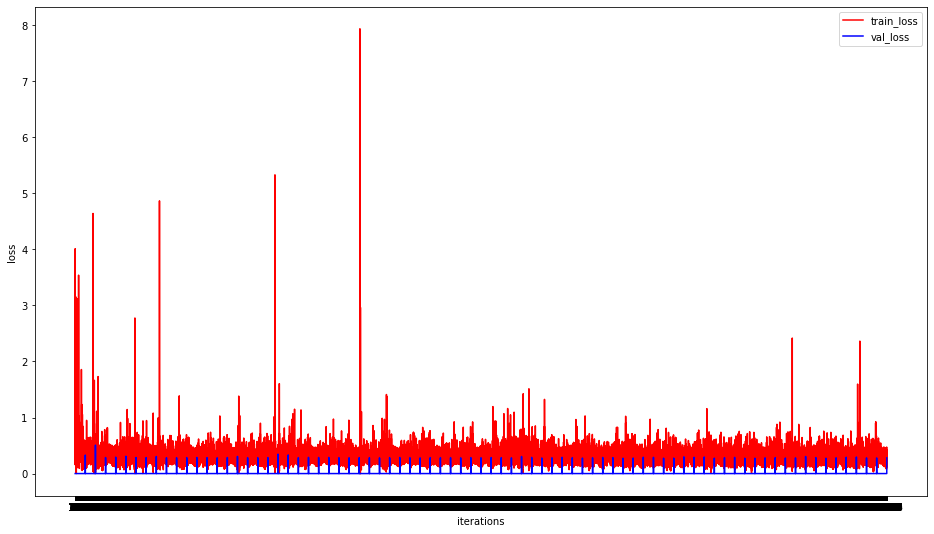

In [11]:
plot_loss(loss_train, loss_val)

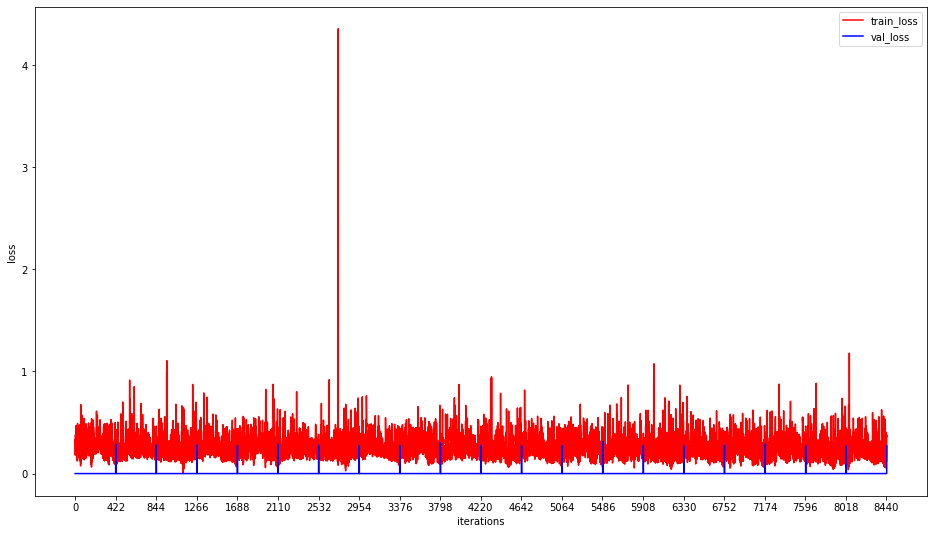

In [21]:
plot_loss(loss_train, loss_val)

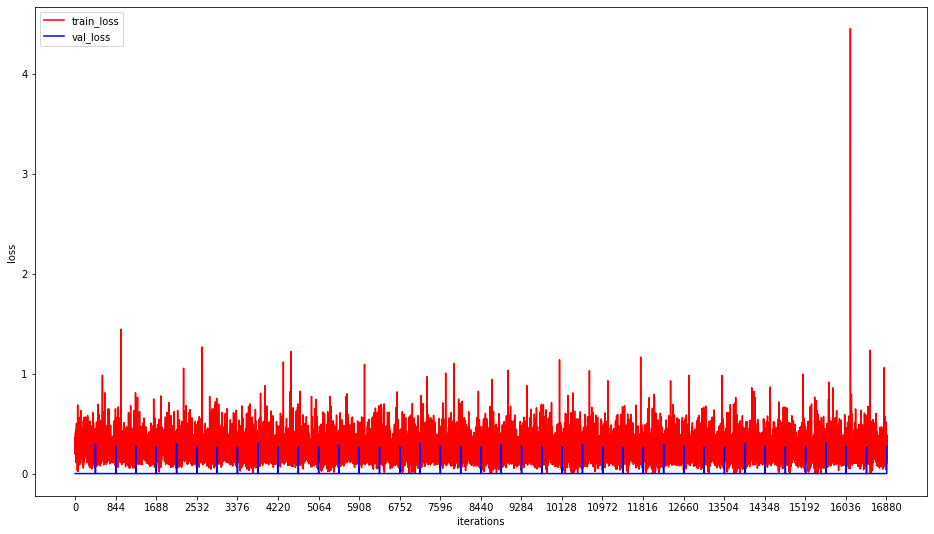

In [23]:
plot_loss(loss_train, loss_val)

In [74]:
import pandas as pd
df = pd.DataFrame(data=np.stack([np.array(range(loss_train.shape[0])), loss_train, loss_val]).T, columns=['iteration', 'loss_train', 'loss_val'])
print(df.shape)
df.to_csv(os.path.join('models', 'restorchism18_medium_weighted_19_2020-09-01-cont10.csv'), index=False)

(8445, 3)


Genre            Precision              Recall
0                 Blues                  nan                 0.0
1             Classical                  nan                 0.0
2               Country                  nan                 0.0
3        Easy Listening                  nan                 0.0
4            Electronic  0.44660194174757284  0.6064030131826742
5          Experimental                  0.0                 0.0
6                  Folk                  nan                 0.0
7               Hip-Hop                  nan                 0.0
8          Instrumental                  nan                 0.0
9         International                  nan                 0.0
10                 Jazz                  nan                 0.0
11  Old-Time / Historic   0.4444444444444444  0.0784313725490196
12                  Pop                  nan                 0.0
13                 Rock  0.48350515463917526  0.7675941080196399
14             Soul-RnB                  nan                 0.0
15               Spoken                  nan                 0.0

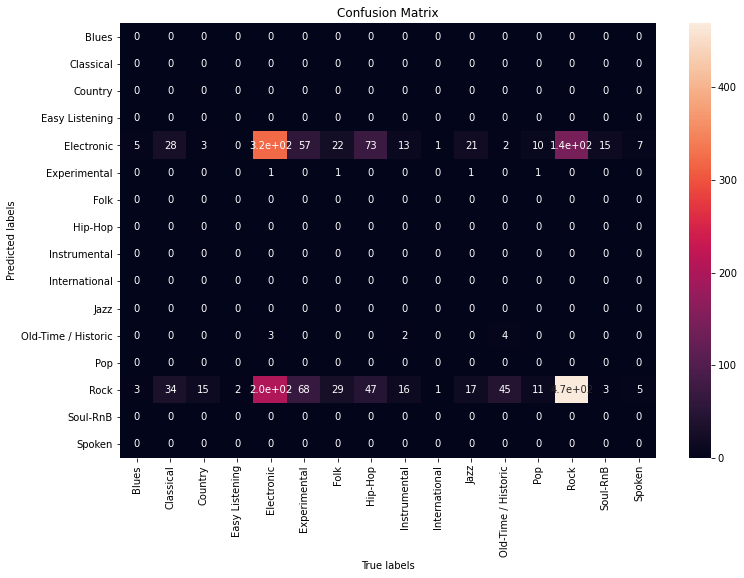

In [18]:
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

Genre            Precision                Recall
0                 Blues                  nan                   0.0
1             Classical   0.3076923076923077    0.6451612903225806
2               Country                  nan                   0.0
3        Easy Listening                  nan                   0.0
4            Electronic  0.49413735343383586    0.5555555555555556
5          Experimental  0.07692307692307693                 0.008
6                  Folk                  nan                   0.0
7               Hip-Hop                0.125  0.008333333333333333
8          Instrumental                  nan                   0.0
9         International                  nan                   0.0
10                 Jazz                  0.0                   0.0
11  Old-Time / Historic   0.1919191919191919    0.7450980392156863
12                  Pop                  nan                   0.0
13                 Rock   0.5784574468085106    0.7119476268412439
14             Soul-RnB                  nan                   0.0
15               Spoken                  0.0                   0.0

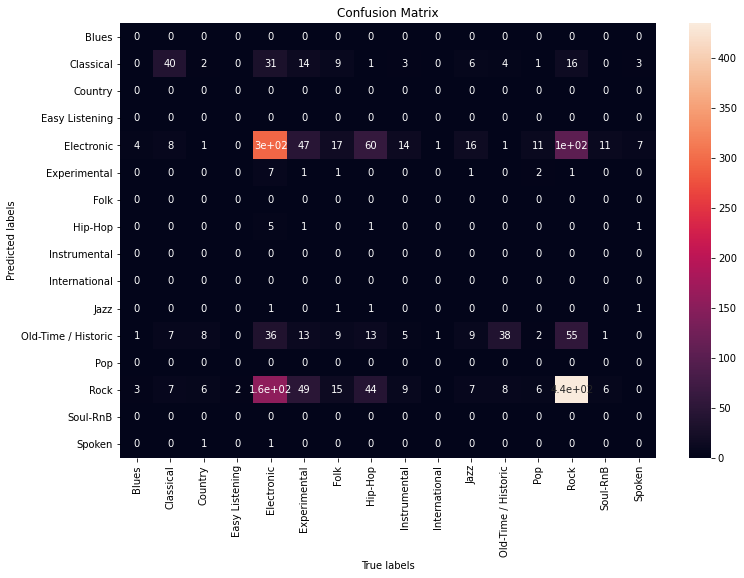

In [25]:
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

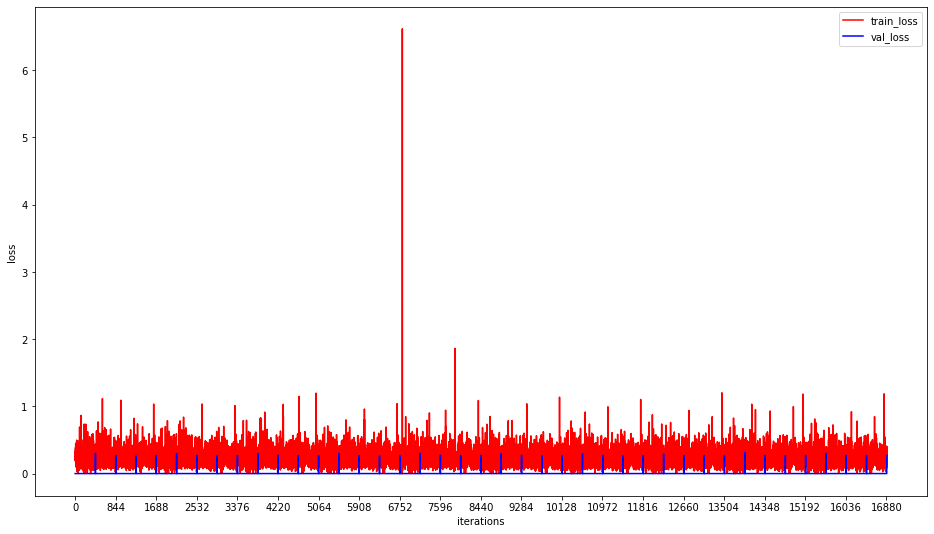

In [28]:
plot_loss(loss_train, loss_val)

Genre             Precision                Recall
0                 Blues                   nan                   0.0
1             Classical   0.30973451327433627    0.5645161290322581
2               Country                   nan                   0.0
3        Easy Listening                   nan                   0.0
4            Electronic    0.5033222591362126    0.5706214689265536
5          Experimental  0.058823529411764705                 0.024
6                  Folk                   nan                   0.0
7               Hip-Hop                  0.25  0.008333333333333333
8          Instrumental                   nan                   0.0
9         International                   nan                   0.0
10                 Jazz                   nan                   0.0
11  Old-Time / Historic    0.2846153846153846    0.7254901960784313
12                  Pop                   0.0                   0.0
13                 Rock    0.5753424657534246    0.7561374795417348
14             Soul-RnB                   nan                   0.0
15               Spoken                   nan                   0.0

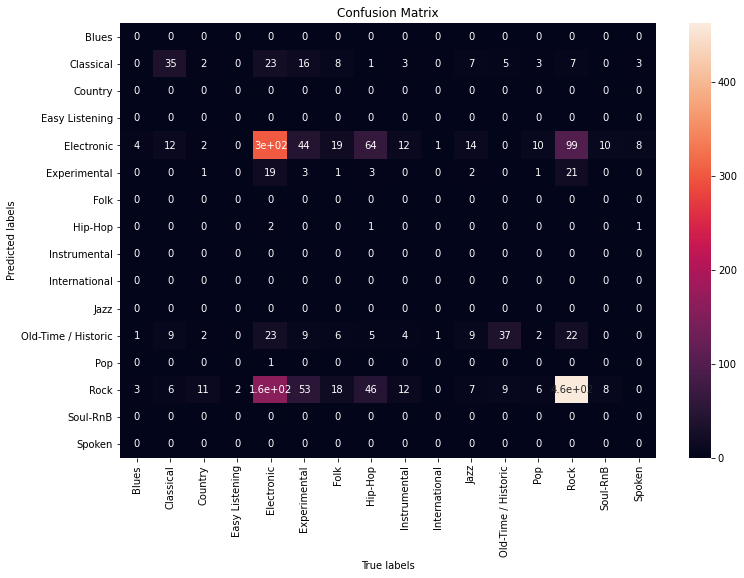

In [30]:
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

In [49]:
data_train.class_distribution

{'Blues': 58,
 'Classical': 495,
 'Country': 142,
 'Easy Listening': 13,
 'Electronic': 4249,
 'Experimental': 1001,
 'Folk': 414,
 'Hip-Hop': 957,
 'Instrumental': 244,
 'International': 14,
 'Jazz': 306,
 'Old-Time / Historic': 408,
 'Pop': 145,
 'Rock': 4878,
 'Soul-RnB': 94,
 'Spoken': 94}

In [50]:
data_val.class_distribution

{'Blues': 8,
 'Classical': 62,
 'Country': 18,
 'Easy Listening': 2,
 'Electronic': 531,
 'Experimental': 125,
 'Folk': 52,
 'Hip-Hop': 120,
 'Instrumental': 31,
 'International': 2,
 'Jazz': 39,
 'Old-Time / Historic': 51,
 'Pop': 22,
 'Rock': 611,
 'Soul-RnB': 18,
 'Spoken': 12}

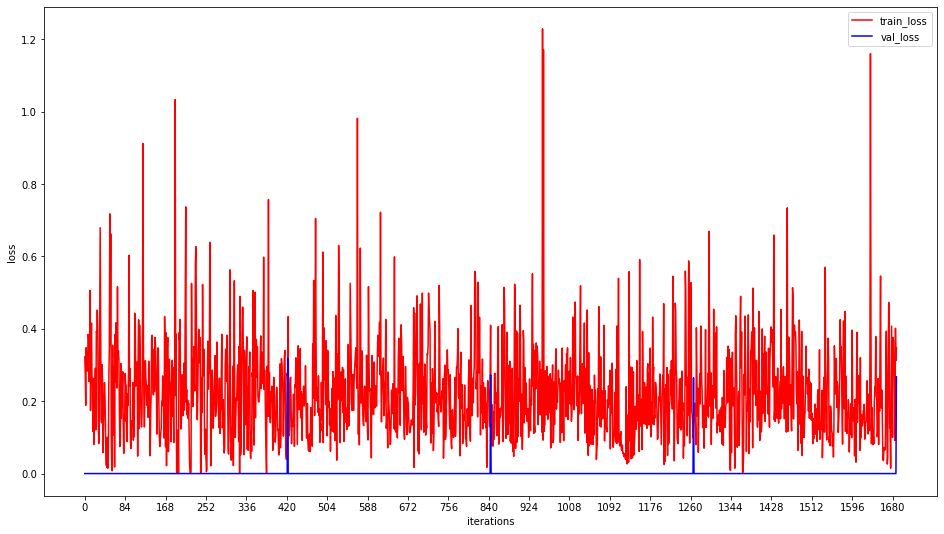

In [53]:
plot_loss(loss_train, loss_val)

Genre            Precision              Recall
0                 Blues                  nan                 0.0
1             Classical  0.28169014084507044  0.6451612903225806
2               Country                  nan                 0.0
3        Easy Listening                  nan                 0.0
4            Electronic             0.515625   0.559322033898305
5          Experimental   0.0967741935483871               0.048
6                  Folk                  nan                 0.0
7               Hip-Hop                  0.0                 0.0
8          Instrumental                  nan                 0.0
9         International                  nan                 0.0
10                 Jazz                  nan                 0.0
11  Old-Time / Historic  0.22699386503067484  0.7254901960784313
12                  Pop                  nan                 0.0
13                 Rock   0.6160949868073878  0.7643207855973814
14             Soul-RnB                  nan                 0.0
15               Spoken                  nan                 0.0

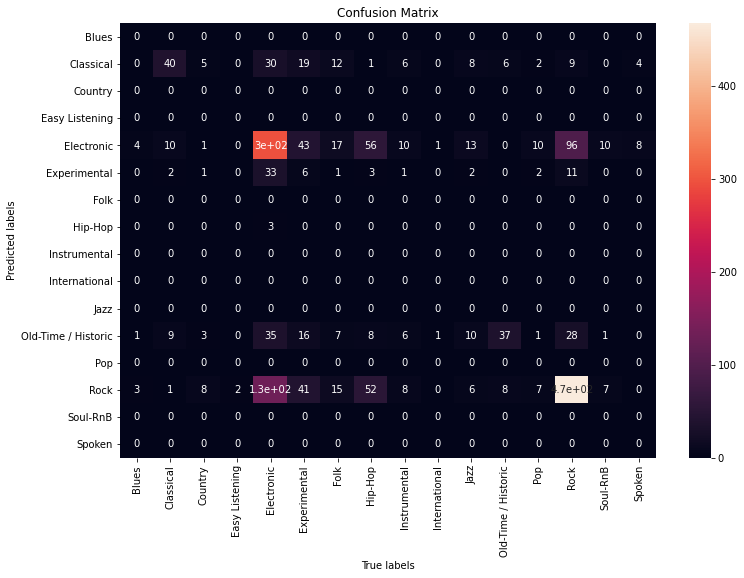

In [55]:
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

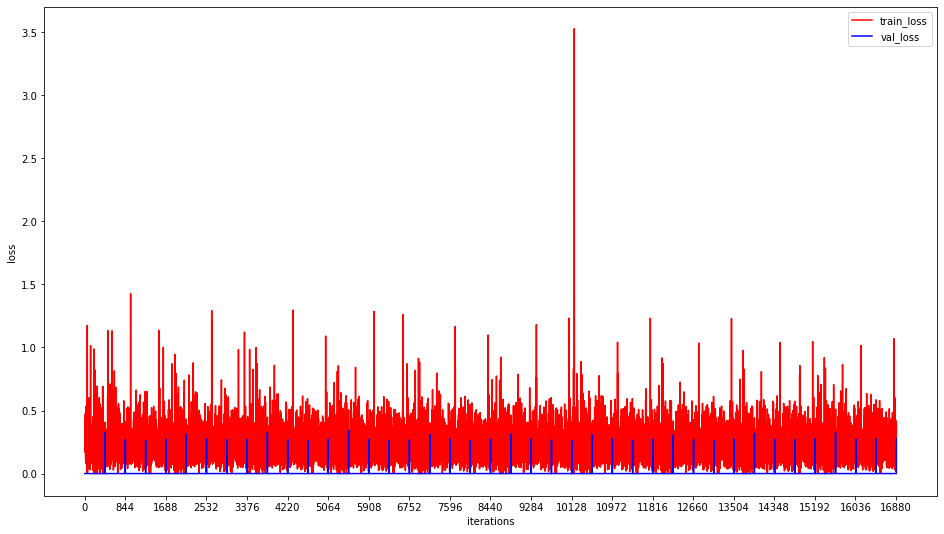

In [58]:
plot_loss(loss_train, loss_val)

Genre            Precision              Recall
0                 Blues                  nan                 0.0
1             Classical  0.28378378378378377  0.6774193548387096
2               Country                  nan                 0.0
3        Easy Listening                  nan                 0.0
4            Electronic   0.5289982425307557  0.5668549905838042
5          Experimental  0.10666666666666667               0.064
6                  Folk                  nan                 0.0
7               Hip-Hop                  0.0                 0.0
8          Instrumental                  nan                 0.0
9         International                  nan                 0.0
10                 Jazz                  nan                 0.0
11  Old-Time / Historic              0.24375  0.7647058823529411
12                  Pop                  nan                 0.0
13                 Rock                0.604  0.7414075286415712
14             Soul-RnB                  nan                 0.0
15               Spoken                  nan                 0.0

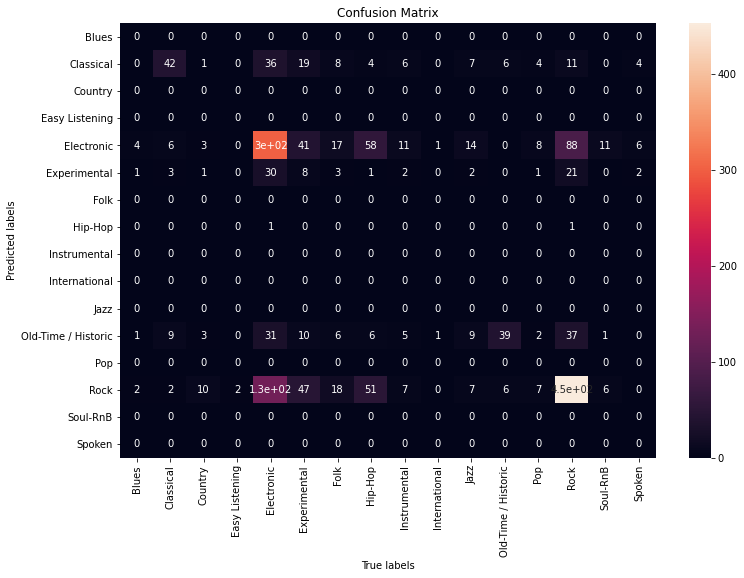

In [59]:
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

### Epoch 60-65

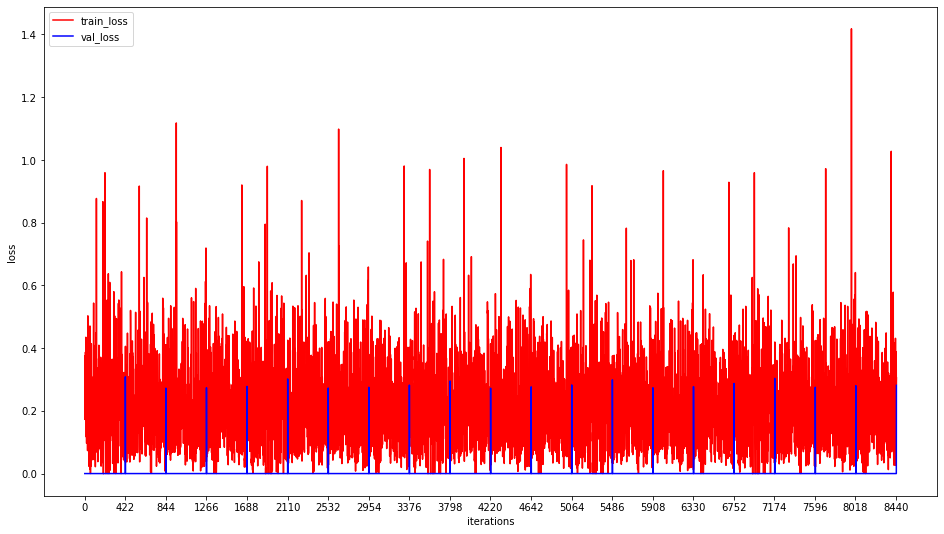

Genre            Precision                Recall
0                 Blues                  nan                   0.0
1             Classical   0.3211009174311927    0.5645161290322581
2               Country                  nan                   0.0
3        Easy Listening                  nan                   0.0
4            Electronic   0.5459363957597173    0.5819209039548022
5          Experimental  0.06542056074766354                 0.056
6                  Folk                  0.0                   0.0
7               Hip-Hop   0.2857142857142857  0.016666666666666666
8          Instrumental                  1.0   0.03225806451612903
9         International                  nan                   0.0
10                 Jazz                  nan                   0.0
11  Old-Time / Historic  0.21311475409836064    0.7647058823529411
12                  Pop                  nan                   0.0
13                 Rock   0.6068493150684932    0.7250409165302782
14             Soul-RnB                  nan                   0.0
15               Spoken                  nan                   0.0

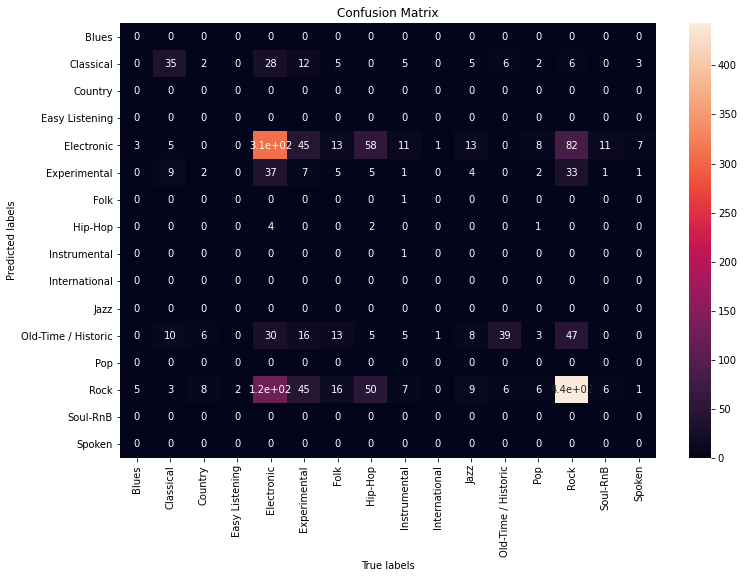

In [63]:
plot_loss(loss_train, loss_val)
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

### Epocsh 66-80

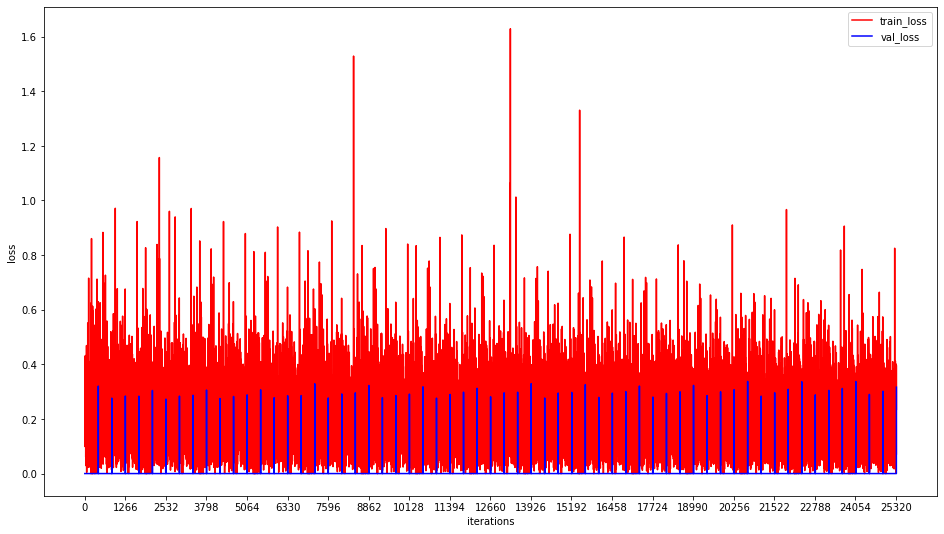

Genre             Precision                Recall
0                 Blues                   nan                   0.0
1             Classical    0.3111111111111111    0.6774193548387096
2               Country                   nan                   0.0
3        Easy Listening                   nan                   0.0
4            Electronic     0.550561797752809    0.5536723163841808
5          Experimental   0.03773584905660377                 0.016
6                  Folk                   0.0                   0.0
7               Hip-Hop    0.2777777777777778  0.041666666666666664
8          Instrumental  0.044444444444444446   0.06451612903225806
9         International                   nan                   0.0
10                 Jazz                   nan                   0.0
11  Old-Time / Historic   0.38461538461538464    0.6862745098039216
12                  Pop                   0.0                   0.0
13                 Rock    0.5825242718446602    0.7855973813420621
14             Soul-RnB                   nan                   0.0
15               Spoken                   nan                   0.0

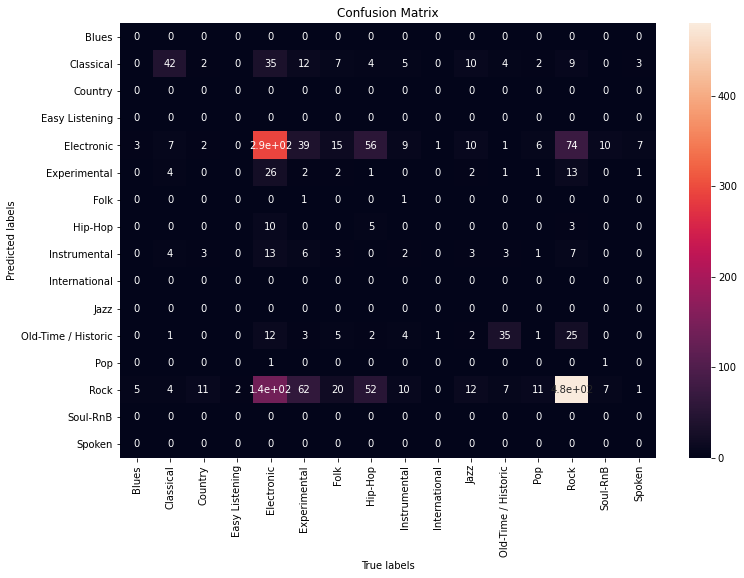

In [66]:
plot_loss(loss_train, loss_val)
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

### Epochs 81-85

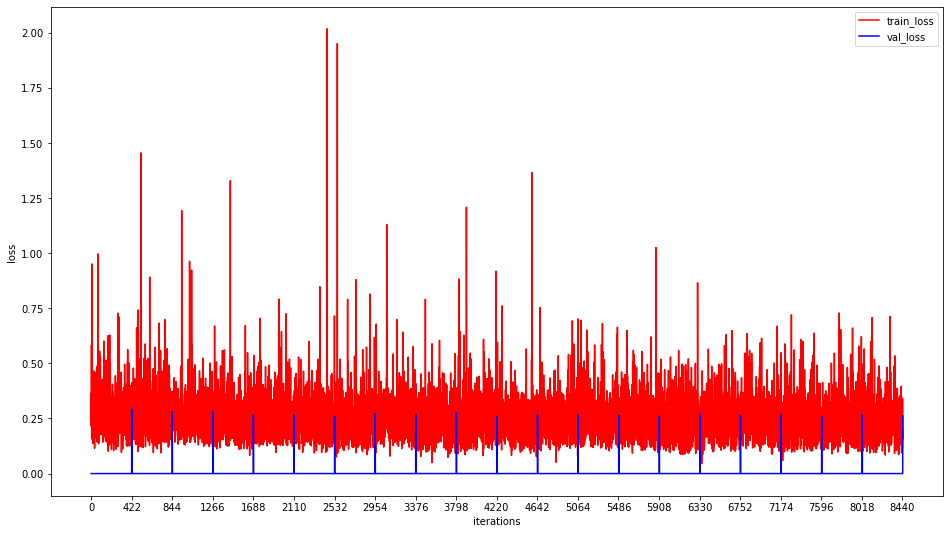

Genre             Precision               Recall
0                 Blues                   nan                  0.0
1             Classical   0.27638190954773867   0.8870967741935484
2               Country  0.010869565217391304  0.05555555555555555
3        Easy Listening                   0.0                  0.0
4            Electronic   0.49923664122137407    0.615819209039548
5          Experimental                  0.12                0.048
6                  Folk                   0.0                  0.0
7               Hip-Hop    0.2571428571428571                 0.15
8          Instrumental                   0.0                  0.0
9         International                   nan                  0.0
10                 Jazz                   0.0                  0.0
11  Old-Time / Historic    0.6363636363636364   0.4117647058823529
12                  Pop                   nan                  0.0
13                 Rock     0.658578856152513   0.6219312602291326
14             Soul-RnB                   nan                  0.0
15               Spoken                   nan                  0.0

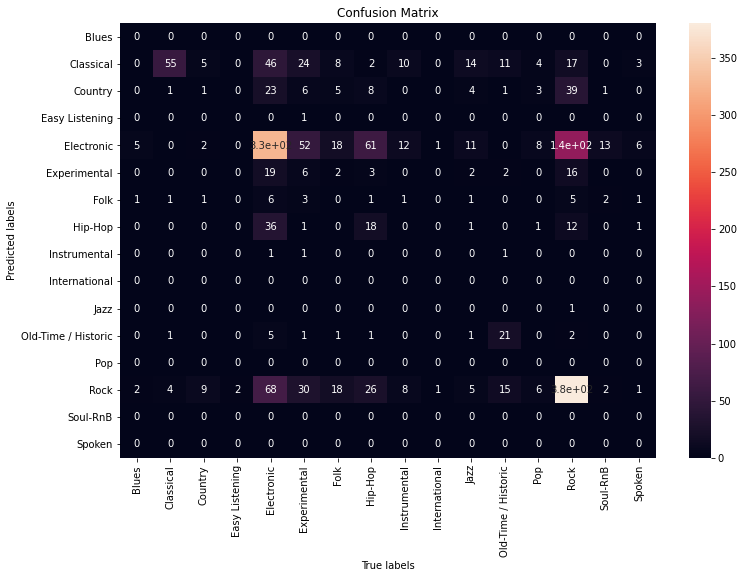

In [70]:
plot_loss(loss_train, loss_val)
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

### Epochs 86-90

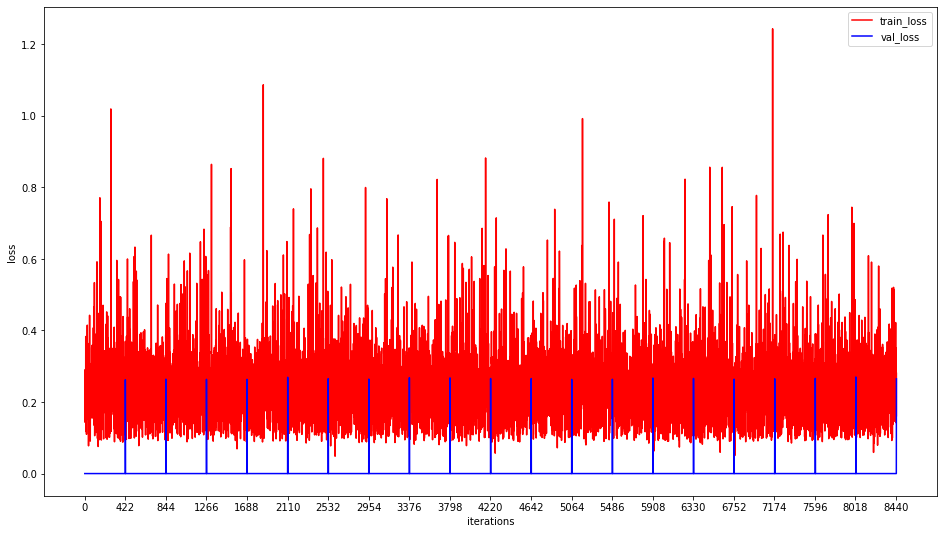

Genre            Precision                Recall
0                 Blues                  nan                   0.0
1             Classical   0.2616822429906542    0.9032258064516129
2               Country                  0.0                   0.0
3        Easy Listening                  0.0                   0.0
4            Electronic  0.44903225806451613     0.655367231638418
5          Experimental  0.11290322580645161                 0.112
6                  Folk  0.08695652173913043  0.038461538461538464
7               Hip-Hop  0.13636363636363635                 0.075
8          Instrumental                  0.0                   0.0
9         International                  nan                   0.0
10                 Jazz                  0.0                   0.0
11  Old-Time / Historic   0.6060606060606061   0.39215686274509803
12                  Pop                  0.0                   0.0
13                 Rock   0.7168367346938775   0.45990180032733224
14             Soul-RnB                  nan                   0.0
15               Spoken                  nan                   0.0

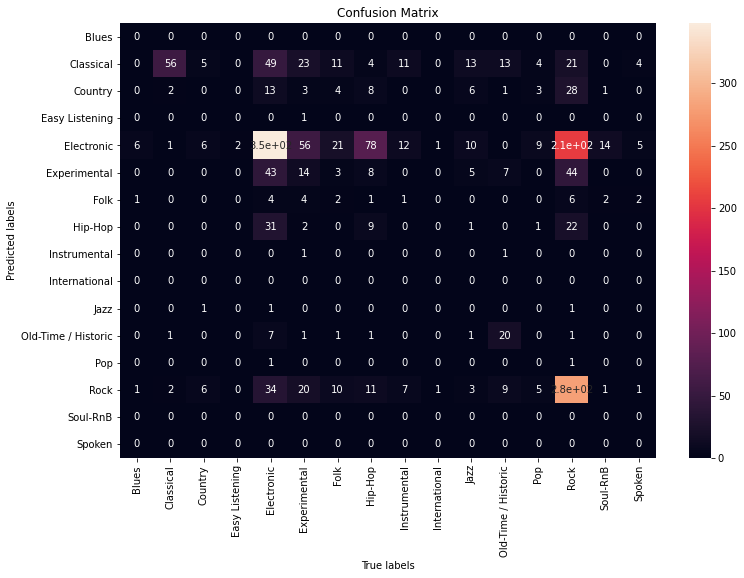

In [73]:
plot_loss(loss_train, loss_val)
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

### Epochs 91-95

In [75]:
model, loss_train, loss_val = train(
    model=model,
    train_loader=DataLoader(data_train, batch_size=8, num_workers=4, shuffle=True),
    loss_fn=torch.nn.CrossEntropyLoss(weight=class_weights),
    optimizer=torch.optim.SGD(model.parameters(), lr=0.001),
    epochs=5,
    val_loader=DataLoader(data_val, batch_size=8, num_workers=0),
    val_count=422,
    model_dir='models',
    model_name='restorchism24_medium_weighted',
    start_epoch=91
)

Epoch 91 | Iteration  1688 | batch loss: 0.19996237754821777
Epoch 92 | Iteration  1688 | batch loss: 0.252921223640441955
Epoch 93 | Iteration  1688 | batch loss: 0.31775784492492676
Epoch 94 | Iteration  1688 | batch loss: 0.101048447191715246


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



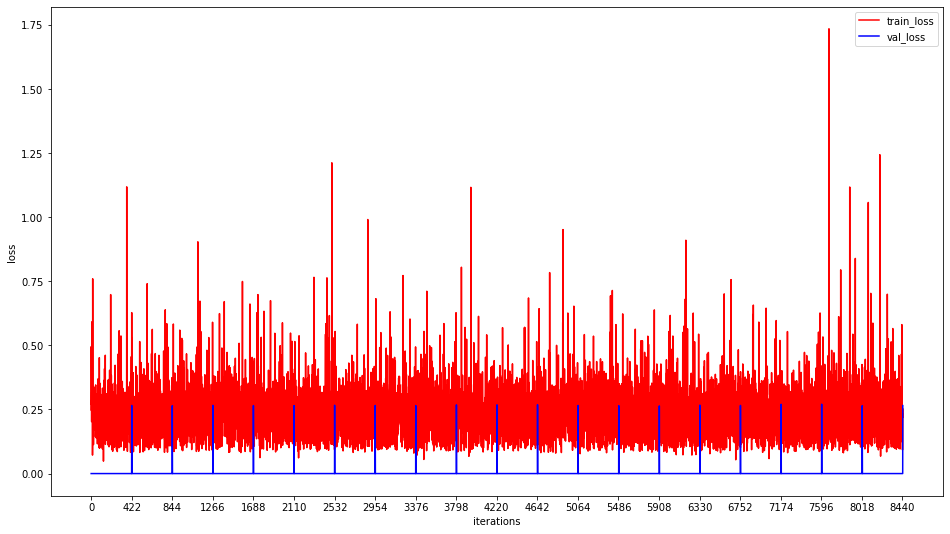

Genre            Precision                Recall
0                 Blues                  nan                   0.0
1             Classical  0.22950819672131148    0.9032258064516129
2               Country                  0.0                   0.0
3        Easy Listening                  nan                   0.0
4            Electronic   0.4473684210526316      0.64030131826742
5          Experimental  0.08130081300813008                  0.08
6                  Folk                  0.1  0.057692307692307696
7               Hip-Hop   0.1509433962264151   0.06666666666666667
8          Instrumental                  0.0                   0.0
9         International                  nan                   0.0
10                 Jazz                  0.0                   0.0
11  Old-Time / Historic   0.6285714285714286   0.43137254901960786
12                  Pop                  0.0                   0.0
13                 Rock   0.7069408740359897    0.4500818330605565
14             Soul-RnB                  nan                   0.0
15               Spoken                  0.0                   0.0

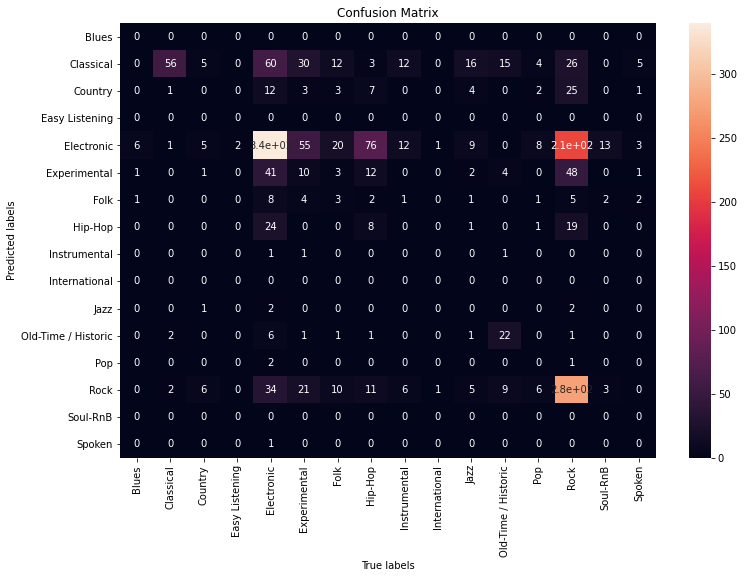

In [76]:
plot_loss(loss_train, loss_val)
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

In [77]:
import pandas as pd
df = pd.DataFrame(data=np.stack([np.array(range(loss_train.shape[0])), loss_train, loss_val]).T, columns=['iteration', 'loss_train', 'loss_val'])
print(df.shape)
df.to_csv(os.path.join('models', 'restorchism18_medium_weighted_19_2020-09-01-cont11.csv'), index=False)

(8445, 3)


### Epochs 96-100

In [78]:
model, loss_train, loss_val = train(
    model=model,
    train_loader=DataLoader(data_train, batch_size=8, num_workers=4, shuffle=True),
    loss_fn=torch.nn.CrossEntropyLoss(weight=class_weights),
    optimizer=torch.optim.SGD(model.parameters(), lr=0.001),
    epochs=5,
    val_loader=DataLoader(data_val, batch_size=8, num_workers=0),
    val_count=422,
    model_dir='models',
    model_name='restorchism24_medium_weighted',
    start_epoch=96
)

Epoch 96 | Iteration  1688 | batch loss: 0.12837067246437073


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



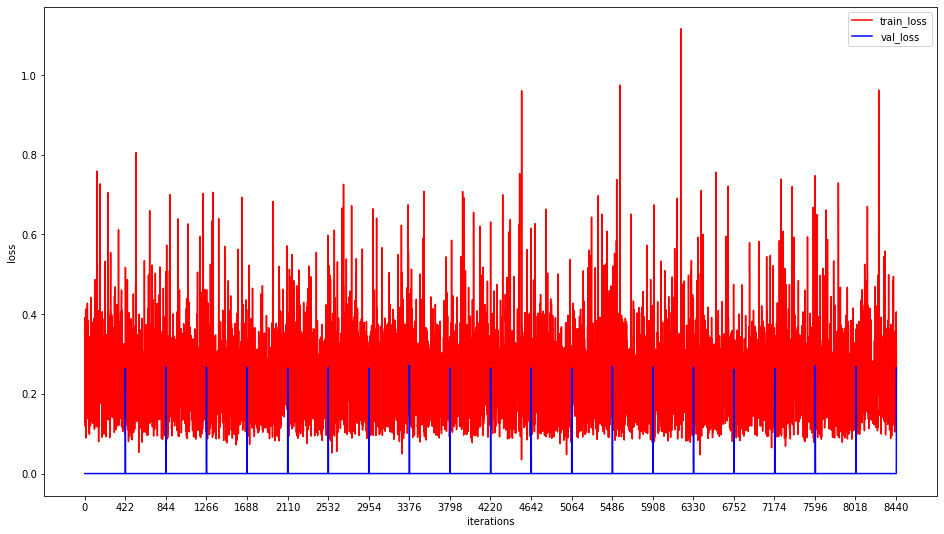

Genre             Precision                Recall
0                 Blues                   nan                   0.0
1             Classical    0.2422907488986784    0.8870967741935484
2               Country                   0.0                   0.0
3        Easy Listening                   0.0                   0.0
4            Electronic   0.46944858420268254    0.5932203389830508
5          Experimental   0.12121212121212122                 0.096
6                  Folk  0.058823529411764705  0.057692307692307696
7               Hip-Hop   0.21739130434782608                 0.125
8          Instrumental                   0.0                   0.0
9         International                   nan                   0.0
10                 Jazz                   0.0                   0.0
11  Old-Time / Historic    0.6052631578947368   0.45098039215686275
12                  Pop                   0.0                   0.0
13                 Rock     0.706855791962175   0.48936170212765956
14             Soul-RnB                   nan                   0.0
15               Spoken                   0.0                   0.0

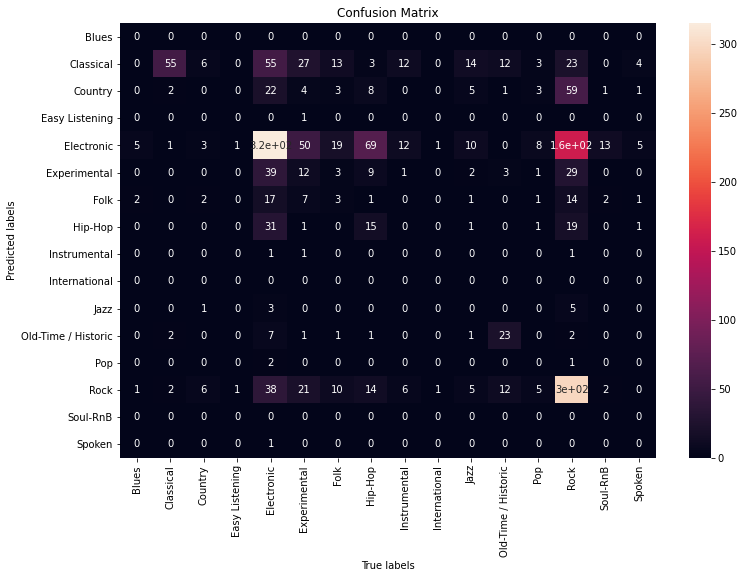

In [79]:
plot_loss(loss_train, loss_val)
evaluate(
    model=model,
    dataset=DataLoader(data_val, batch_size=1, num_workers=4),
    classes=data_val.genres
)

In [80]:
import pandas as pd
df = pd.DataFrame(data=np.stack([np.array(range(loss_train.shape[0])), loss_train, loss_val]).T, columns=['iteration', 'loss_train', 'loss_val'])
print(df.shape)
df.to_csv(os.path.join('models', 'restorchism18_medium_weighted_19_2020-09-01-cont12.csv'), index=False)

(8445, 3)


# Zakljucak
Model je nakon svake epohe sacuvan u direktorijumu "models" koji nije prebacen na git zbog ukupnog obima od 5GB. Matrica konfuzije konacno izgleda malo pristojnije, a sumiranje rezultata eksperimenata se moze videti u PDF prezentaciji koja je okacena na repozitorijum pored ove sveske.

Dalji koraci ukljucuju duzi trening, isprobavanje ciklicnog ucenja uz zamenu optimizatora za SGD, Nestorovljev spust itd.